In [14]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import skimage
import math
import matplotlib as mpl
from scipy.ndimage import gaussian_filter
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np
from skimage.color import rgb2hed, hed2rgb
import matplotlib.pyplot as plt
from skimage import data, segmentation, feature, future
from sklearn.ensemble import RandomForestClassifier
from functools import partial
from collections import Counter
import seaborn as sns
from PIL import Image
from PIL.TiffTags import TAGS

Image.MAX_IMAGE_PIXELS = None # to prevent loading errors


import utils as ut

In [2]:
# upload the scale factors

keys = ['ND', 'HFD8', 'HFD14']

scales = []

for key in keys:
    path = f"/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/SPT/{key}/outs/spatial/scalefactors_json.json"
    
    tmp = pd.read_json(path, lines=True)
    tmp['key'] = key
    # tmp['lowres_spot_diameter_pixels'] = tmp['spot_diameter_fullres'] * tmp['tissue_lowres_scalef']
    # tmp['lowres_spot_diameter_units'] = tmp['lowres_spot_diameter_pixels'] * 65
    
    scales.append(tmp)
    
scales = pd.concat(scales, ignore_index=True)
print(scales)
# print(scales[['key', 'spot_diameter_fullres', 'lowres_spot_diameter_pixels']])


def getscalebar(key, length, scales=scales):
    """Length is physical units """
    lookup = scales.loc[scales['key'] == key]
    pixels = lookup['spot_diameter_fullres'].values[0]
    scaleFactor = lookup['tissue_hires_scalef'].values[0]
    units = 55 # mircons
    fullResPixels = (pixels * length) / units
    lowResPixels = fullResPixels * scaleFactor
    return lowResPixels

def transScaleBar(hiresX, ultrahiresX, lowResPixels):
    """A function to resize the scale bar based on the 
    ultra hir-res image shape """
    newPixels = (lowResPixels * ultrahiresX) / hiresX
    return newPixels

    
getscalebar('ND', length=100)

   spot_diameter_fullres  tissue_hires_scalef  fiducial_diameter_fullres  \
0             257.195160             0.050684                 415.469120   
1             257.368127             0.051089                 415.748513   
2             257.404844             0.049124                 415.807825   

   tissue_lowres_scalef    key  
0              0.015205     ND  
1              0.015327   HFD8  
2              0.014737  HFD14  


23.701345795450475

In [3]:
# upload the hires images
dirPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/SPT/"

keys = ['ND', 'HFD8', 'HFD14']

hires = {}

for key in keys:
    fullpath = f"{dirPath}{key}/outs/spatial/tissue_hires_image.png"
    img = skimage.io.imread(fullpath)
    hires[key] = img

print('done')

done


In [4]:
# get the ultra hires images
imDir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/images/hires/"

keyMap = {
    '1105-LM-1C' : 'HFD8',
    '1105-LM-1D' : 'HFD14', 
    '1105-LM-1B' : 'ND',
}

ultrahires = {}

for f in os.listdir(imDir):
    if f.endswith("tif"):
        SPTkey = f.replace(".tif", "")
        if not SPTkey in keyMap.keys():
            continue
        
        fullpath = f"{imDir}{f}"
        img = skimage.io.imread(fullpath, as_gray=True)
        key = keyMap[SPTkey]
        print(key, img.shape)
        ultrahires[key] = img

print('done')

HFD8 (39147, 33122)
HFD14 (40713, 33149)
ND (39460, 33174)
done


ND (3000, 2000)
HFD8 (3000, 2000)
HFD14 (3000, 2000)


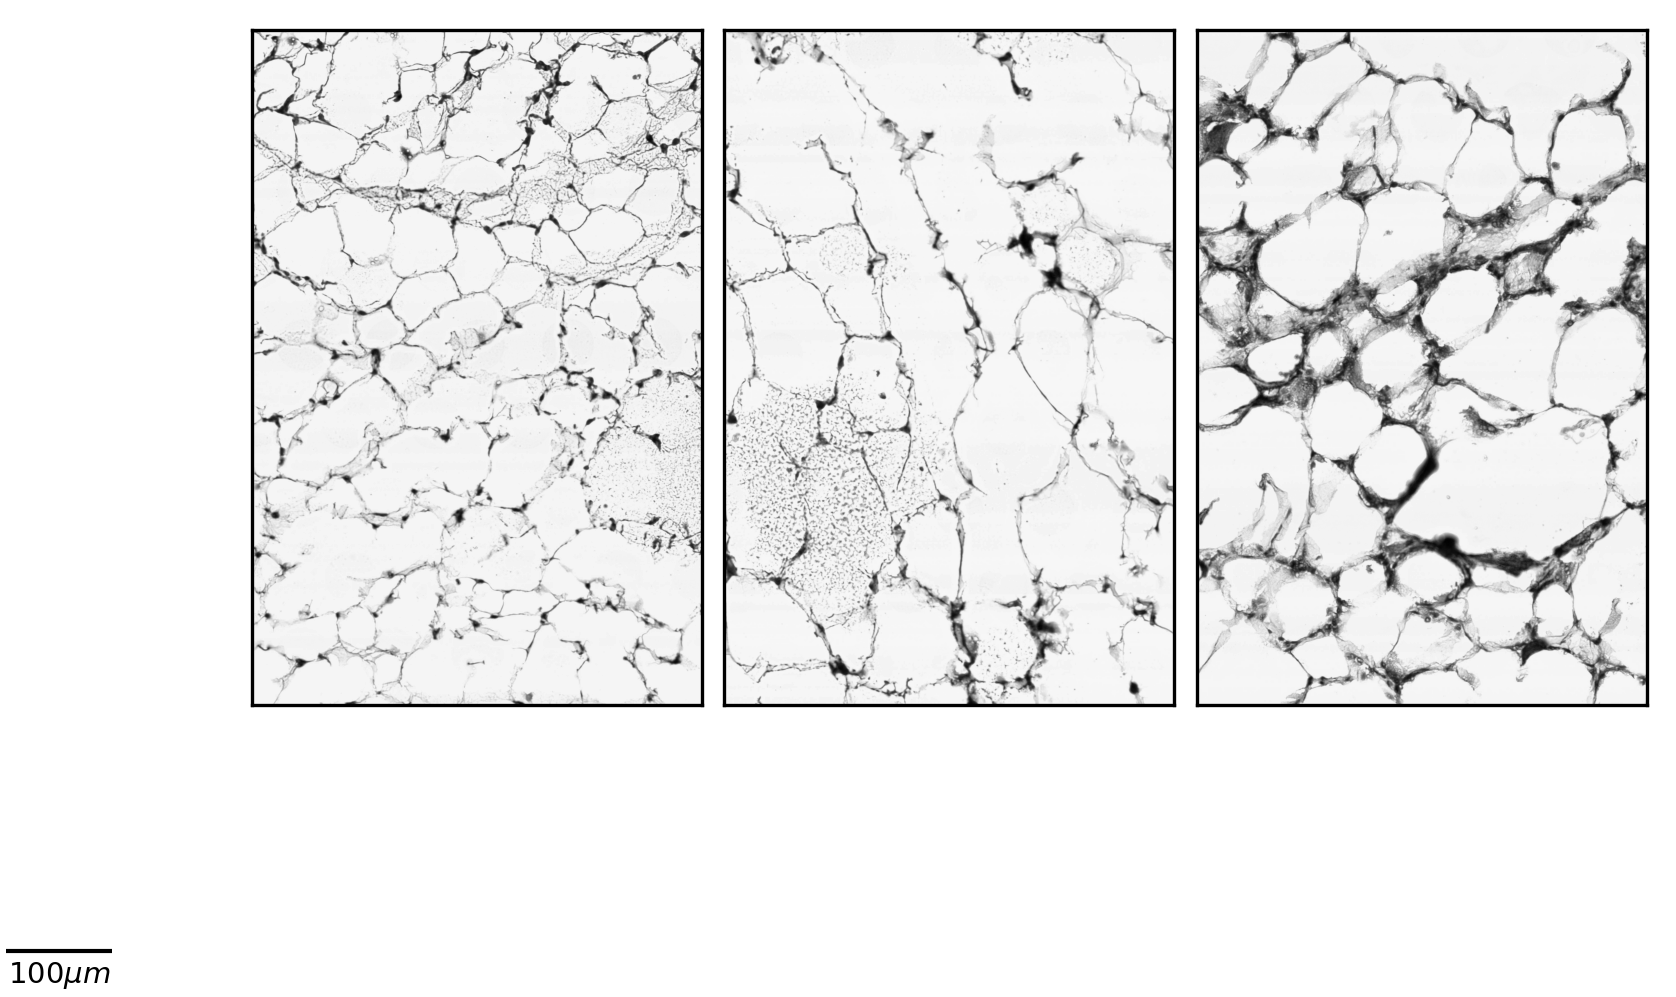

In [62]:
key = 'ND'
xws = 1500
yws = 1000
# ws = 500
microns = 100 # number of microns for the scale bar

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = 'w'

fig, axs = plt.subplots(1, 3)
axs = axs.ravel()

for i, key in enumerate(keys):

    ultra = ultrahires[key]
    img = hires[key]

    sbarHires = getscalebar(key, microns)
    sbarUltra = transScaleBar(img.shape[0], ultra.shape[0], sbarHires)

    xmean = ultra.shape[0] // 2
    ymean = ultra.shape[1] // 2

    window = ultra[xmean-xws:xmean+xws,ymean-yws:ymean+yws]
    print(key, window.shape)
    axs[i].imshow(window, cmap='binary_r')

    scalebar = AnchoredSizeBar(axs[i].transData,
                               sbarUltra, 
                               f'{microns}' + r'$\mu m$', 
                               loc='lower left', 
                               # pad=0.2,
                               color='k',
                               frameon=False,
                               size_vertical=1,
                               bbox_to_anchor=(0.5, 0.5, 0, 0),
                               fontproperties={'size':7})
    # if i == 0:
    #     axs[i].add_artist(scalebar)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    
# plt.tight_layout()
plt.gca().add_artist(scalebar)
plt.subplots_adjust(wspace=0.05, hspace=0)

In [ ]:
# imDir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/images/hires/"

# keyMap = {
#     '1105-LM-1C' : 'HFD8',
#     '1105-LM-1D' : 'HFD14', 
#     '1105-LM-1B' : 'ND',
# }

# imgs = {}

# for f in os.listdir(imDir):
#     if f.endswith("tif"):
#         SPTkey = f.replace(".tif", "")
#         if not SPTkey in keyMap.keys():
#             continue
        
#         fullpath = f"{imDir}{f}"
#         img = skimage.io.imread(fullpath, as_gray=True)
#         key = keyMap[SPTkey]
#         print(key, img.shape)
#         imgs[key] = img

# print('done')

In [ ]:
key = 'ND'
t = imgs[key]
ws = 1000
xmean = t.shape[0] // 2
ymean = t.shape[1] // 2

plt.rcParams['figure.dpi'] = 100


plt.imshow(t[xmean-ws:xmean+ws,ymean-ws:ymean+ws], cmap='binary_r')
ax = plt.gca()

label = 50
units = getscalebar(key, label)

scalebar = AnchoredSizeBar(ax.transData,
                           units, 
                           f'{label}' + r'$\mu m$', 
                           'lower left', 
                           pad=0.5,
                           color='k',
                           frameon=False,
                           size_vertical=1,
                           fontproperties={'size':10})

ax.add_artist(scalebar)

In [ ]:




# imDir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/images/hires/"

# keyMap = {
#     '1105-LM-1C' : 'HFD8',
#     '1105-LM-1D' : 'HFD14', 
#     '1105-LM-1B' : 'ND',
# }

# imgs = {}

# for f in os.listdir(imDir):
#     if f.endswith("tif"):
#         SPTkey = f.replace(".tif", "")
#         if not SPTkey in keyMap.keys():
#             continue
        
#         fullpath = f"{imDir}{f}"
        
#         with Image.open(fullpath) as img:
#             meta_dict = {TAGS[key] : img.tag[key] for key in img.tag}
            
#         break
        
#         # img = skimage.io.imread(fullpath, as_gray=True)
#         # key = keyMap[SPTkey]
#         # print(key, img.shape)
#         # imgs[key] = img

# # print('done')


In [ ]:
meta_dict.keys()

In [ ]:
meta_dict['ImageDescription']